In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap
import joblib

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.layers import LSTM, Bidirectional, Dense
from tensorflow.keras.optimizers import Adam
import warnings


c:\Users\srich\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv(
    "power_with_hourly_weekly_consumption.csv",
    parse_dates=['Datetime']
)

df.set_index("Datetime", inplace=True)
df.dropna(inplace=True)


In [3]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_kWh_min,Hourly_Consumption_kWh,Weekly_Consumption_kWh
Datetime,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,0.017400,1.882467,76.660600
2006-12-24,5.376,0.046,237.57,22.6,0.0,0.0,18.0,0.089600,4.028000,291.285467
2006-12-31,0.210,0.000,243.10,0.8,0.0,0.0,0.0,0.003500,0.676233,328.941967
2007-01-07,1.504,0.280,241.95,6.2,0.0,2.0,18.0,0.025067,0.903200,249.351133
2007-01-14,4.646,0.062,234.31,19.8,0.0,0.0,17.0,0.077433,3.340567,269.605567


In [4]:
df['Daily_Consumption_kWh'] = df['Hourly_Consumption_kWh'].resample('D').transform('sum')


In [5]:
features = [
'Global_active_power',
'Global_reactive_power',
'Voltage',
'Global_intensity',
'Sub_metering_1',
'Sub_metering_2',
'Sub_metering_3',
'Energy_kWh_min',
'Hourly_Consumption_kWh',
'Daily_Consumption_kWh',
'Weekly_Consumption_kWh'
]

df = df[features]


In [6]:
df.head()

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3,Energy_kWh_min,Hourly_Consumption_kWh,Daily_Consumption_kWh,Weekly_Consumption_kWh
Datetime,,,,,,,,,,,
2006-12-17,1.044,0.152,242.73,4.4,0.0,2.0,0.0,0.017400,1.882467,1.882467,76.660600
2006-12-24,5.376,0.046,237.57,22.6,0.0,0.0,18.0,0.089600,4.028000,4.028000,291.285467
2006-12-31,0.210,0.000,243.10,0.8,0.0,0.0,0.0,0.003500,0.676233,0.676233,328.941967
2007-01-07,1.504,0.280,241.95,6.2,0.0,2.0,18.0,0.025067,0.903200,0.903200,249.351133
2007-01-14,4.646,0.062,234.31,19.8,0.0,0.0,17.0,0.077433,3.340567,3.340567,269.605567


In [7]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df.values)


In [8]:
def create_sequences(data, window):
    X, y = [], []
    for i in range(len(data)-window):
        X.append(data[i:i+window])
        y.append(data[i+window,-3:])
    return np.array(X), np.array(y)

window = 24
X,y = create_sequences(scaled_data,window)


In [9]:
split=int(0.8*len(X))

X_train,X_test=X[:split],X[split:]
y_train,y_test=y[:split],y[split:]


In [10]:
model=Sequential()

model.add(Conv1D(64,3,activation='relu',
input_shape=(window,X_train.shape[2])))

model.add(MaxPooling1D(2))
model.add(Dropout(0.2))

model.add(Bidirectional(LSTM(128,return_sequences=True)))
model.add(LSTM(128))

model.add(Dense(3))


c:\Users\srich\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.compile(
optimizer=Adam(0.001),
loss='mse',
metrics=['mae']
)


In [12]:
model.fit(
X_train,
y_train,
epochs=50,
batch_size=32,
validation_split=0.1
)


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 19s 828ms/step - loss: 0.0757 - mae: 0.2065 - val_loss: 0.0256 - val_mae: 0.1309
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0448 - mae: 0.1669 - val_loss: 0.0505 - val_mae: 0.1866
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0435 - mae: 0.1538 - val_loss: 0.0499 - val_mae: 0.1885
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0367 - mae: 0.1439 - val_loss: 0.0258 - val_mae: 0.1380
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0335 - mae: 0.1392 - val_loss: 0.0211 - val_mae: 0.1226
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 142ms/step - loss: 0.0346 - mae: 0.1488 - val_loss: 0.0249 - val_mae: 0.1391
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0313 - mae: 0.1370 - val_loss: 0.0301 - val_mae: 0.1477
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0316 - mae: 0.1307 - val_loss: 0.0273 - val_mae: 0.1401
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0304 - mae:

In [13]:
predictions=model.predict(X_test)

mse=mean_squared_error(y_test,predictions)
mae=mean_absolute_error(y_test,predictions)

print("MSE:",mse)
print("MAE:",mae)


2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 2s/step
MSE: 0.016444167415149303
MAE: 0.10385306473048295


In [14]:
model.save("energy_model.h5")
joblib.dump(scaler,"scaler.pkl")


['scaler.pkl']

In [15]:
X_train_flat=X_train.reshape(X_train.shape[0],-1)
X_test_flat=X_test.reshape(X_test.shape[0],-1)


In [16]:
def predict_hourly(data):
    data=data.reshape(data.shape[0],24,11)
    return model.predict(data)[:,0]


In [17]:
background=X_train_flat[
np.random.choice(X_train_flat.shape[0],50,replace=False)
]


In [18]:
explainer=shap.KernelExplainer(
predict_hourly,
background
)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


In [19]:
X_sample=X_test_flat[:10]

shap_hourly=explainer.shap_values(X_sample)


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 98s 24ms/step


 10%|█         | 1/10 [01:48<16:15, 108.36s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 79s 20ms/step


 20%|██        | 2/10 [03:12<12:32, 94.10s/it] 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 77s 19ms/step


 30%|███       | 3/10 [04:34<10:20, 88.65s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 85s 21ms/step


 40%|████      | 4/10 [06:12<09:13, 92.26s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 93s 23ms/step


 50%|█████     | 5/10 [07:50<07:52, 94.51s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 84s 21ms/step


 60%|██████    | 6/10 [09:20<06:11, 92.88s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 153ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 98s 24ms/step


 70%|███████   | 7/10 [11:04<04:49, 96.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step


 80%|████████  | 8/10 [12:29<03:05, 92.92s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 83s 21ms/step


 90%|█████████ | 9/10 [13:58<01:31, 91.50s/it]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 179ms/step
4025/4025 ━━━━━━━━━━━━━━━━━━━━ 80s 20ms/step


100%|██████████| 10/10 [15:23<00:00, 92.35s/it]


In [20]:
shap_hourly=shap_hourly.reshape(10,24,11)
X_sample_3d=X_sample.reshape(10,24,11)


In [21]:
shap_hourly_2d=np.mean(shap_hourly,axis=1)
X_sample_2d=np.mean(X_sample_3d,axis=1)


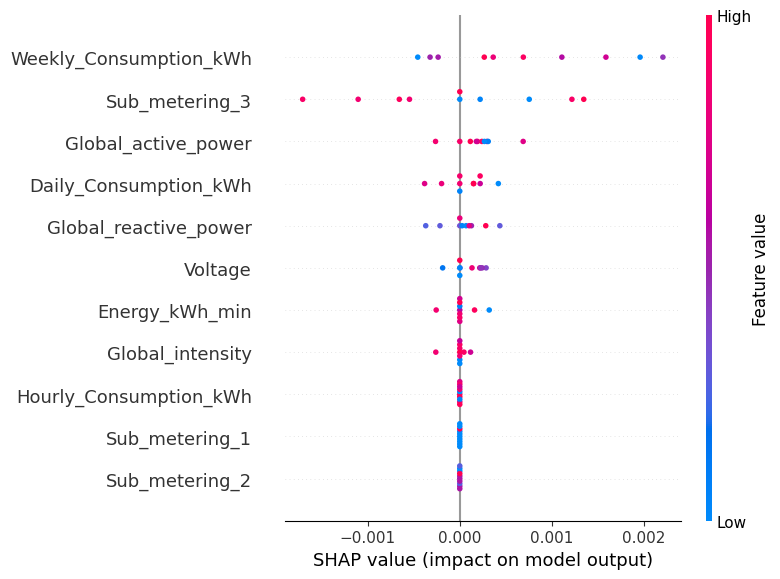

In [22]:
plt.figure(figsize=(10,6))

shap.summary_plot(
shap_hourly_2d,
X_sample_2d,
feature_names=features
)


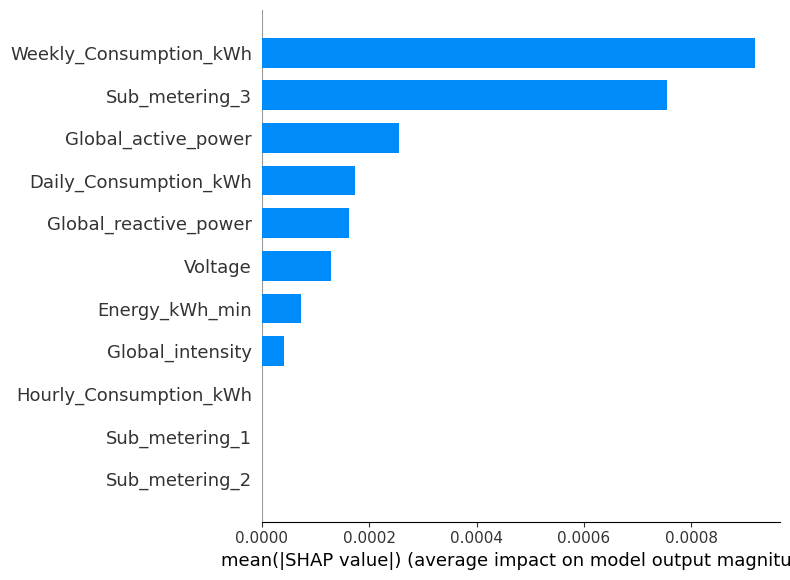

In [23]:
plt.figure(figsize=(10,6))

shap.summary_plot(
shap_hourly_2d,
X_sample_2d,
feature_names=features,
plot_type="bar"
)


##HOURLY FORECAST GRAPH

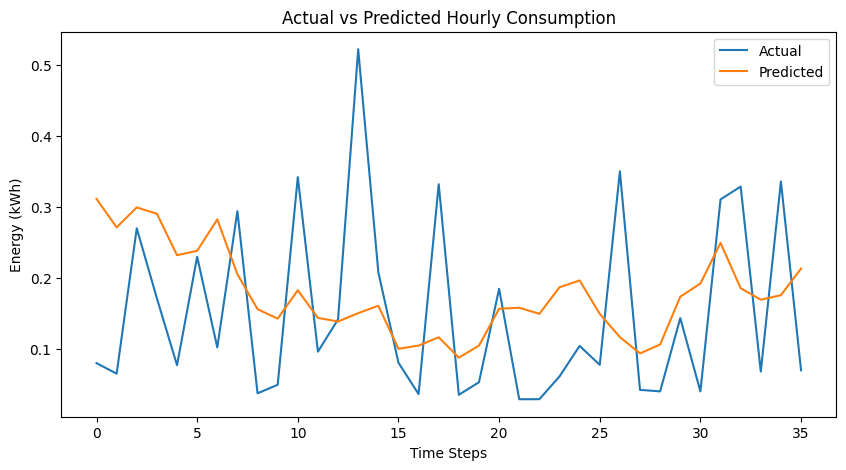

In [24]:
plt.figure(figsize=(10,5))

plt.plot(y_test[:200,0])
plt.plot(predictions[:200,0])

plt.title("Actual vs Predicted Hourly Consumption")
plt.xlabel("Time Steps")
plt.ylabel("Energy (kWh)")
plt.legend(["Actual","Predicted"])

plt.show()



## WEEKLY FORECAST GRAPH

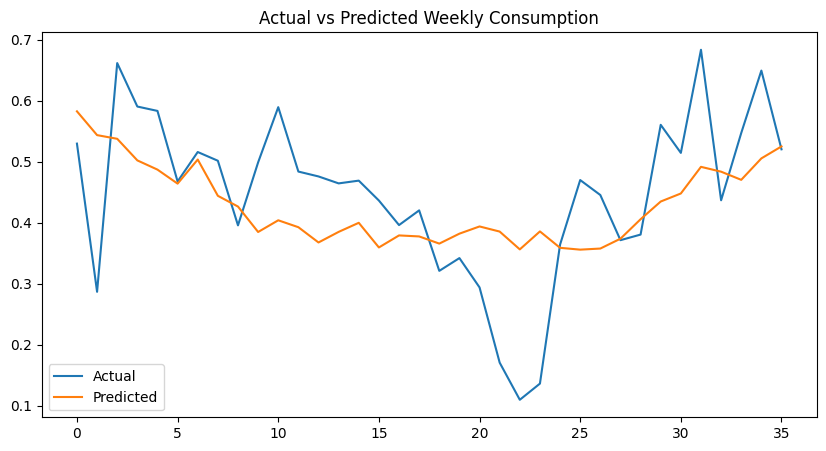

In [25]:
plt.figure(figsize=(10,5))

plt.plot(y_test[:200,2])
plt.plot(predictions[:200,2])

plt.title("Actual vs Predicted Weekly Consumption")
plt.legend(["Actual","Predicted"])

plt.show()


In [27]:
history = model.fit(
    X_train,
    y_train,
    epochs=50,
    batch_size=32,
    validation_split=0.1
)

import pickle
with open("history.pkl","wb") as f:
    pickle.dump(history.history,f)



Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 226ms/step - loss: 0.0195 - mae: 0.1046 - val_loss: 0.0172 - val_mae: 0.1035
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0194 - mae: 0.0990 - val_loss: 0.0193 - val_mae: 0.1140
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 133ms/step - loss: 0.0181 - mae: 0.1015 - val_loss: 0.0216 - val_mae: 0.1238
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 136ms/step - loss: 0.0203 - mae: 0.1037 - val_loss: 0.0189 - val_mae: 0.1113
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 135ms/step - loss: 0.0193 - mae: 0.1017 - val_loss: 0.0213 - val_mae: 0.1227
Epoch 6/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 139ms/step - loss: 0.0189 - mae: 0.1004 - val_loss: 0.0201 - val_mae: 0.1148
Epoch 7/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 141ms/step - loss: 0.0169 - mae: 0.0925 - val_loss: 0.0228 - val_mae: 0.1263
Epoch 8/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 170ms/step - loss: 0.0170 - mae: 0.0954 - val_loss: 0.0207 - val_mae: 0.1172
Epoch 9/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 137ms/step - loss: 0.0177 - mae: 

In [28]:
import pickle

with open("history.pkl","rb") as f:
    history = pickle.load(f)


## LOSS CURVE

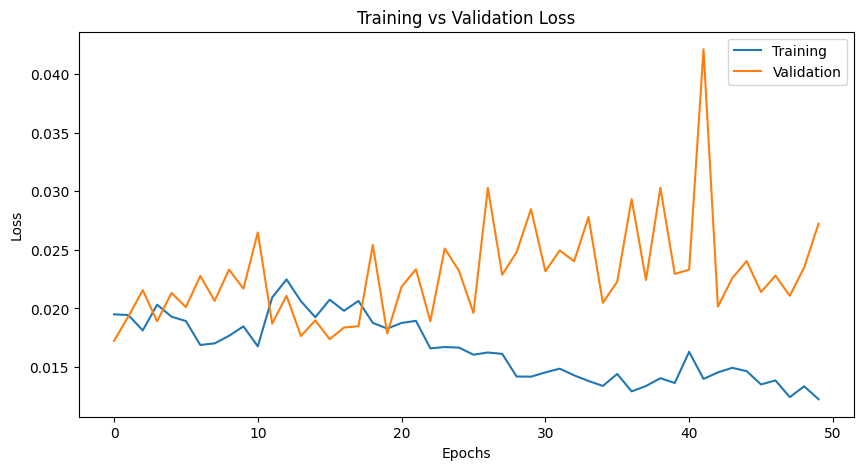

In [29]:
plt.figure(figsize=(10,5))

plt.plot(history['loss'])
plt.plot(history['val_loss'])

plt.title("Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Training","Validation"])

plt.show()


In [ ]:
pip install plotly

In [33]:
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'browser'

hourly_corr = df.corr()[['Hourly_Consumption_kWh']].sort_values(
    by='Hourly_Consumption_kWh',
    ascending=False
)

fig = px.imshow(
    hourly_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r'
)

fig.update_layout(
    title="Correlation with Hourly Energy Consumption",
    height=600
)

fig.show()


In [34]:
daily_corr = df.corr()[['Daily_Consumption_kWh']].sort_values(
    by='Daily_Consumption_kWh',
    ascending=False
)

fig = px.imshow(
    daily_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r'
)

fig.update_layout(
    title="Correlation with Daily Energy Consumption",
    height=600
)

fig.show()


In [35]:
weekly_corr = df.corr()[['Weekly_Consumption_kWh']].sort_values(
    by='Weekly_Consumption_kWh',
    ascending=False
)

fig = px.imshow(
    weekly_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r'
)

fig.update_layout(
    title="Correlation with Weekly Energy Consumption",
    height=600
)

fig.show()



In [36]:
full_corr = df.corr()

fig = px.imshow(
    full_corr,
    text_auto=True,
    aspect="auto",
    color_continuous_scale='RdBu_r'
)

fig.update_layout(
    title="Full Feature Correlation Matrix",
    height=800
)

fig.show()
